In [330]:
import xarray as xr
import cftime
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import gc

Load Datasets using xarray

In [358]:
present = xr.open_dataset("b.e11.BRCP85C5CNBDRD.f09_g16.001.cice.h.meltb_nh.200601-208012.nc") #2006-2081 data
past = xr.open_dataset("b.e11.B20TRC5CNBDRD.f09_g16.005.cice.h.meltb_nh.192001-200512.nc") #1920-2005 data

Combine both datasets, print result

In [517]:
presentAlign,pastAlign = xr.align(present,past, join="outer")
combined = presentAlign.combine_first(pastAlign)

In [520]:
print(combined)

<xarray.Dataset>
Dimensions:      (nj: 104, ni: 320, nvertices: 4, time: 1932, d2: 2)
Coordinates:
  * time         (time) object 1920-02-01 00:00:00 ... 2081-01-01 00:00:00
    TLAT         (nj, ni) float32 30.38 30.38 30.38 30.38 ... nan nan nan nan
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    ULAT         (nj, ni) float32 30.6 30.61 30.61 30.61 ... nan nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.3 324.5 ... nan nan nan nan
Dimensions without coordinates: nj, ni, nvertices, d2
Data variables: (12/18)
    ANGLE        (nj, ni) float32 0.000967 0.001934 0.0029 ... nan nan nan
    ANGLET       (nj, ni) float32 0.0004741 0.001422 0.00237 ... nan nan nan
    HTE          (nj, ni) float32 5.032e+04 5.033e+04 5.034e+04 ... nan nan nan
    HTN          (nj, ni) float32 1.068e+05 1.068e+05 1.068e+05 ... nan nan nan
    blkmask      (nj, ni) float32 160.0 160.0 160.0 160.0 ... nan nan nan nan
    dxt          (nj, ni) float32 1.07e+05 1.07

Masking Arrays to remove NA values at Latitude and Longitude for present(2006-2080) array

In [529]:
tlon = combined['TLON'].values
tlat = combined['TLAT'].values


tlonMask=np.isnan(combined['TLON'])
tlatMask=np.isnan(combined['TLAT'])

tlon[tlonMask] = 0
tlat[tlatMask] = 0

Group data by year, average for all datapoints within that year  

Create Latitude and Longitude variables  

    - nan values for land  
    
    
Create 'meltb' variable : Basal Ice Melt  

    -datapoints for each latitude/longitude pairing


In [586]:
annmean=combined.groupby('time.year').mean('time')
tlong = combined['TLON']
tlat = combined['TLAT']
meltb = annmean['meltb']


Graphing without <span style="color:red">without cartesian interpolation</span>.

/usr/local/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


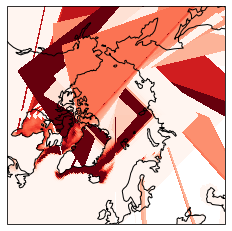

In [652]:
f=plt.figure(figsize=(4,4))
ax=plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 50], crs=ccrs.PlateCarree())
ax.coastlines()
im = plt.pcolormesh(tlong,tlat,meltb.isel(year=0),transform=ccrs.PlateCarree(),vmin=0,vmax=0.5,cmap="Reds") 
    

***Interpolation of latitude, longitude and meltb to flattened meshgrid.***

In [588]:
#old locations
lonorig_flat=tlong.values.flatten()
lon_edge = 210-180
lonorig_flat[lonorig_flat>lon_edge] = lonorig_flat[lonorig_flat>lon_edge] -360 #fix for ugly white stripe 
#moves white strip to the edge of the plot
latorig_flat=tlat.values.flatten()
orig_loc=(lonorig_flat,latorig_flat)

#new locations
londelt=0.5
latdelt=0.5

minlon = np.floor(np.min(lonorig_flat))+londelt/2
maxlon = np.ceil(np.max(lonorig_flat))+londelt/2
lonnew=np.arange(minlon, maxlon ,londelt)
latnew=np.arange(-90,90+latdelt/2,latdelt)

lonnew_mesh,latnew_mesh=np.meshgrid(lonnew,latnew)

lonnew_flat=lonnew_mesh.flatten()
latnew_flat=latnew_mesh.flatten()
new_loc=(lonnew_flat,latnew_flat)

#flatten variable to interpolate
flat_var=meltb.isel(year=0).values.flatten()

#run interpolation
interpolated=griddata(orig_loc,flat_var,new_loc)

interpolated_reshaped=np.reshape(interpolated,np.shape(lonnew_mesh)) #need to reshape output from 1-d array, to 2-d array

Graphing <span style="color:red">with cartesian interpolation</span>.

In [641]:
def plot_melt(year):

    #grab interpolated data based on year
    #flatten variable to interpolate
    flat_var=meltb.isel(year=year).values.flatten()
    #run interpolation
    interpolated=griddata(orig_loc,flat_var,new_loc)
    interpolated_reshaped=np.reshape(interpolated,np.shape(lonnew_mesh)) #need to reshape output from 1-d array, to 2-d array

    #was subplot
    f=plt.figure(figsize=(6,6))
    ax=plt.axes(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 50], crs=ccrs.PlateCarree())
    ax.coastlines()
    im = plt.pcolormesh(lonnew,latnew,interpolated_reshaped,transform=ccrs.PlateCarree(),vmin=0,vmax=0.5,cmap="Reds") 
    
    cb=plt.colorbar(im,shrink=0.75)
    cb.set_label('Basal Sea Ice Melt (cm/day)')
    plt.title(f"Average Arctic Ice Melt, {1920+year}")
    plt.savefig(f"melt/melt_year{year}",facecolor='white')
    #plt.show()

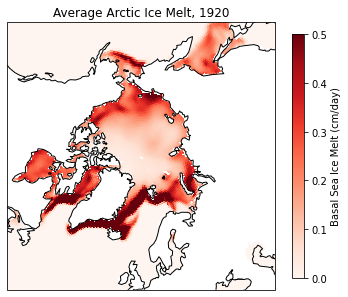

In [653]:
for i in range(1):
    plot_melt(i)